# Mini project: Simulating Pac-Man

## Introduction

In this mini project we will be trying to emulate the behaviours of the Pac-Man videogame. Since we have a lot of limitations with what we can actually accomplish with a Vrep environment, we will be adapting the rules of the game, starting as simple as possible and iterating over the main behaviours that we develop.

## First iteration: making Pac-Man search for food

We started by making a basic maze in Vrep using paths. The idea was to not have a physical wall that could block the vision of the ePuck sensors. That way we could have an ePuck that could navigate a maze using the floor sensors and still be able to see all the food in other corridors of the maze with the rest of its sensors.

With that idea in mind we developed the scene `maze-small.ttt`. In there we can see a grid-like maze with some food as spheres and an ePuck.

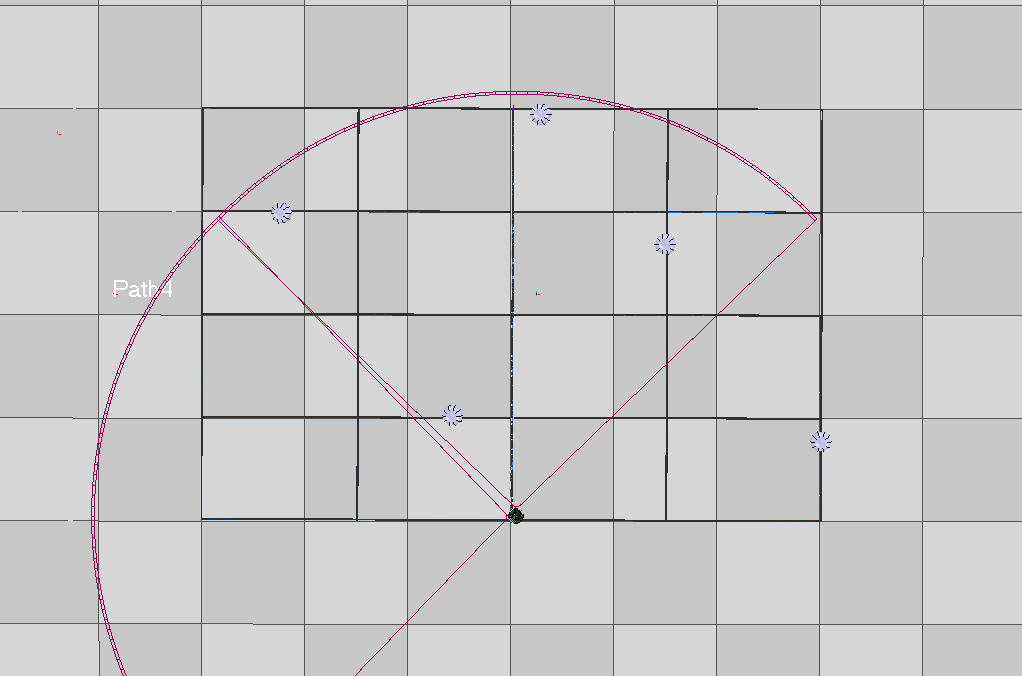

In order to make the ePuck navigate the maze, we devised a very simple algorithm that stored the direction in which the ePuck had to turn on intersections. If the epuck detected something of interest on the left sensor for example, it would store that direction and it would turn left the next time it found a corridor intersection. Since Pac-Man can never turn more than 180 degrees this algorithm adhered to the rules of the game.

We developed this two behaviors to make this possible:


In [ ]:
def line_following(robot):
    floor_left, floor_middle, floor_right = robot.floor_sensor()
    # if can go right and wants to go right it turns there
    if floor_middle == 1.0 and floor_right == 1.0 and robot.rotate == 'right':
        return  [1.0, 0]
    # if can go left and wants to go left it turns there
    if floor_middle == 1.0 and floor_left == 1.0 and robot.rotate == 'left':
        return  [0, 1.0]
    # if can go straight goes straight
    if floor_middle == 1.0: return [1.0, 1.0]
    # if no sensor is activated, the epuck is in risk of exiting the line
    # and has to re-center itself again
    if floor_left == 0.0 and floor_right == 0.0: return [1.0, 0]
    # otherwise goes on the only direction a sensor detects there's a line just in case
    return [floor_right, floor_left]

def detect_food(robot):
    left, right = robot.prox_activations(tracked_objects=["Sphere"])
    # if it detects food it stores the direction where it will have to turn on the next
    # intersection in order to eat it.
    if (left > 0 or right > 0):
        robot.rotate = 'left' if left > right else 'right'
        
epuck.rotate = 'no'
epuck.attach_behavior(line_following, freq=10)
epuck.attach_routine(detect_food, freq=1)

We had to do some param tweaking with this algorithm and the ePuck's max velocity, but it ended up working very reliably.

The next step was to make the ePuck eat the food, not only collide with it. Since we had to follow the Pac-Man rules, we couldn't make food appear everywhere randomly. We had to place it ourselves in the maze. That's why we decided we couldn't use the routine for food aparition we used in class.

We ended up developing our own eat method reverse-engineering the library we were given to do this exercise. We ended up with this eat routine:

In [ ]:
def eat(robot):            
    robot_pos = array(robot.position())
    for obj in simulator.eatable_objects:
        try:
            obj_pos = array(simulator.get_object_position(obj))
        except:
            break
        if norm(robot_pos - obj_pos) < 0.1:
            simulator.eatable_objects.remove(obj)
            simulator.remove_object(obj)

simulator.eatable_objects = ['Sphere_1', 'Sphere_2', 'Sphere_3', 'Sphere_4', 'Sphere_5']
epuck.attach_routine(eat, freq=1)
epuck.start_routine(eat)

And with that, we ended up having an ePuck that was actively trying to find and eat all the food navigating a maze.

There were some shortcomings that we ended up fixing on the next iteration. Mainly that the food was spherical and tended to roll out of the maze paths and ended up being inacessible for the ePuck.

Here's the final code for the `maze-small.ttt`:

In [ ]:
from numpy.linalg import norm
from numpy import array

from simulator_interface import open_session, close_session
simulator, epuck1 = open_session(n_epucks=1)

# First reduce the maximum speed
epuck1.max_speed = 3

def line_following(robot):
    floor_left, floor_middle, floor_right = robot.floor_sensor()
    # if can go right
    if floor_middle == 1.0 and floor_right == 1.0 and robot.rotate == 'right':
        return  [1.0, 0]
    # if can go left
    if floor_middle == 1.0 and floor_left == 1.0 and robot.rotate == 'left':
        return  [0, 1.0]
    if floor_middle == 1.0: return [.3, .3]
    if floor_left == 0.0 and floor_right == 0.0: return [0.1, 0]
    return [floor_right/2.0, floor_left/2.0]

def detect_food(robot):
    left, right = robot.prox_activations(tracked_objects=["Sphere"])
    if (left > 0 or right > 0):
        robot.rotate = 'left' if left > right else 'right'
        
def eat(robot):            
    robot_pos = array(robot.position())
    for obj in simulator.eatable_objects:
        try:
            obj_pos = array(simulator.get_object_position(obj))
        except:
            break
        if norm(robot_pos - obj_pos) < 0.1:
            simulator.eatable_objects.remove(obj)
            simulator.remove_object(obj)

simulator.eatable_objects = ['Sphere_1', 'Sphere_2', 'Sphere_3', 'Sphere_4', 'Sphere_5']
epuck1.attach_routine(eat, freq=1)
epuck1.start_routine(eat)

epuck1.detach_all_behaviors()
epuck1.rotate = 'no'
epuck1.attach_behavior(line_following, freq=10)
epuck1.attach_routine(detect_food, freq=1)
epuck1.start_routine(detect_food)
epuck1.start_all_behaviors()

## Second iteration: make Pac-Man compete with other Pac-Mans

We had some problems in order to add Ghosts. Basically we couldn't find a way to make Ghosts ignore collisions with the Pac-Man food scattered around the maze and that broke all of our game. We thought that instead of having Ghosts we could have more than one Pac-Man and that they could compete to see who would eat more food.

That was the main idea of `maze-small-cuboid.ttt`. In there we continued with the grid-like maze and added two ePucks more. We also made the food square instead of round so it didn't move during the simulation.

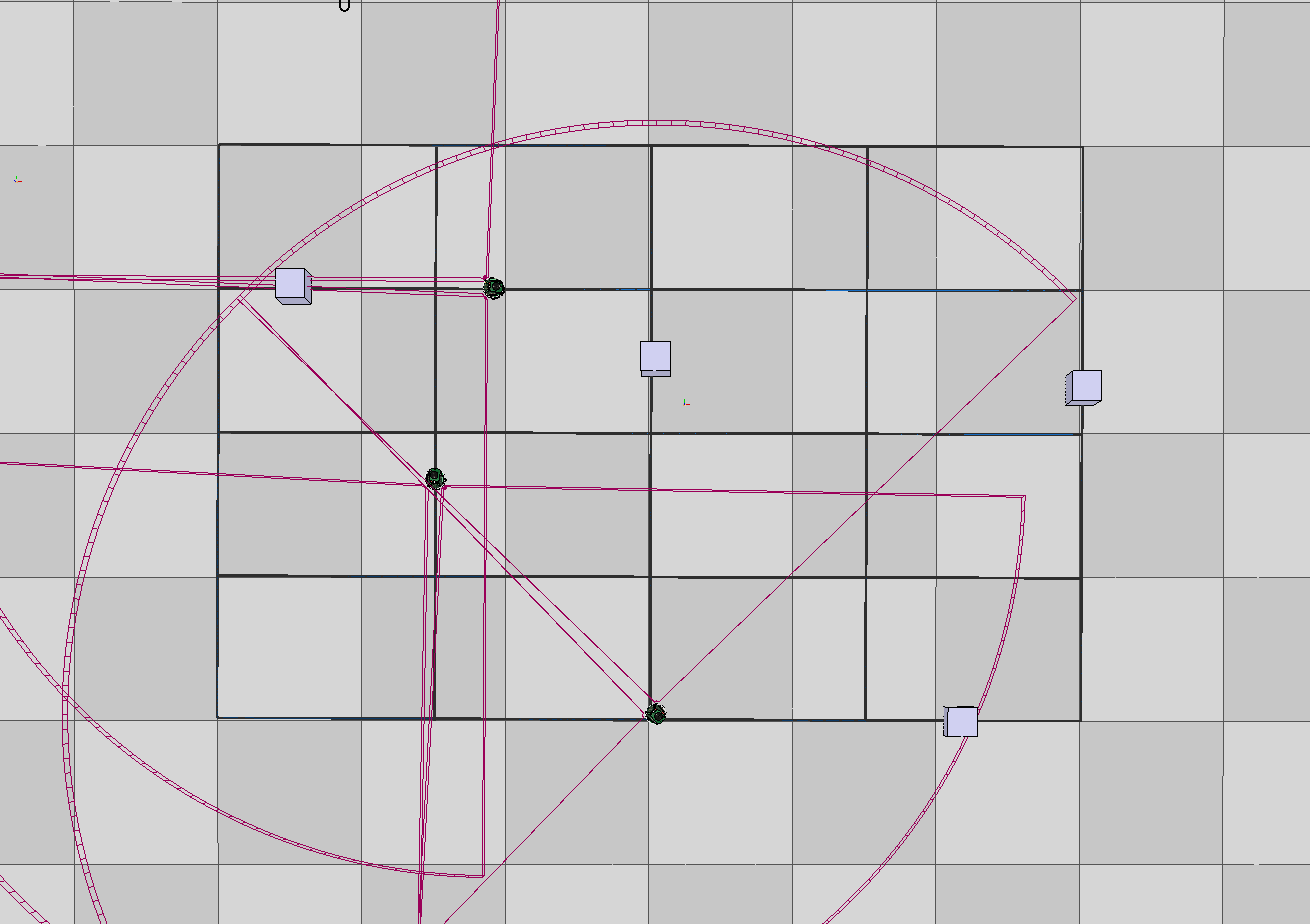

We put the same `line_following` and `detect_food` behaviours as before for each ePuck. We also added a counter `num_eats` that counted how many times that ePuck ate food so we could compare their performances.

What we saw is that ePucks were getting stuck when they collided with each other. That's why we ended up making them "kill" other ePucks on impact when colliding with them (just like Ghosts do in-game).

Finally, we made the ePucks go for other ePucks like they were food in order to have "predator" ePucks. Here's the full code for this iteration:

In [ ]:
from numpy.linalg import norm
from numpy import array

from simulator_interface import open_session, close_session
simulator, epuck1, epuck2, epuck3 = open_session(n_epucks=3)

# First reduce the maximum speed
for e in simulator.robots:
    e.max_speed = 3
    e.num_eats = 0
    e.dead = False

def line_following(robot):
    floor_left, floor_middle, floor_right = robot.floor_sensor()
    # if can go right
    if floor_middle == 1.0 and floor_right == 1.0 and robot.rotate == 'right':
        return  [1.0, 0]
    # if can go left
    if floor_middle == 1.0 and floor_left == 1.0 and robot.rotate == 'left':
        return  [0, 1.0]
    if floor_middle == 1.0: return [.3, .3]
    if floor_left == 0.0 and floor_right == 0.0: return [0.1, 0]
    return [floor_right/2.0, floor_left/2.0]

def detect_food(robot):
    left, right = robot.prox_activations(tracked_objects=['Cuboid', 'ePuck#'])
    if (left > 0 or right > 0):
        robot.rotate = 'left' if left > right else 'right'
        
def eat(robot): 
    try:
        robot_pos = array(robot.position())
    except:
        print ('robot unavailable')
        robot.stop_all_behaviors()
        robot.detach_all_behaviors()
        robot.stop_all_routines()
        robot.dead = True
        print ('score: ' + str(robot.num_eats))
        return
    for obj in simulator.eatable_objects:
       
        try:
            obj_pos = array(simulator.get_object_position(obj))
            if norm(robot_pos - obj_pos) < 0.05 :
                continue
        except:
            break
        if norm(robot_pos - obj_pos) < 0.1 :
            simulator.eatable_objects.remove(obj)
            if obj.startswith('Cuboid'):
                robot.num_eats = robot.num_eats+1
            else:
                if robot.num_eats==0:
                    continue
            simulator.remove_object(obj)

simulator.eatable_objects = ['Cuboid4','Cuboid0', 'Cuboid1', 'Cuboid2', 'Cuboid3', 'ePuck', 'ePuck#0', 'ePuck#1']

for e in simulator.robots:
    e.detach_all_behaviors()
    e.attach_routine(eat, freq=1)
    e.start_routine(eat)
    e.rotate = 'no'
    e.attach_behavior(line_following, freq=10)
    e.attach_routine(detect_food, freq=1)
    e.start_routine(detect_food)
    e.start_all_behaviors()

## Third iteration: power up behaviour

We wanted to emulate what happens in the original game when Pac-Man eats a power-up. Suddenly all Ghosts stop pursuing him and start fleeing. Now Pac-Man becomes the predator and the Gosts become the prey.

We did this in `maze-powerup.ttt`. In there, we have two ePucks and a set of power ups. 

In [ ]:
close_session(simulator)